Fit interpretable models to the training set and test on validation sets.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

import imodels
from rulevetting.api import validation
from rulevetting.projects.csi_pecarn.dataset import Dataset

MODELS_DIR = './models/11'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

In [2]:
df_train, df_tune, df_test = Dataset().get_data()
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def]
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def]
X_test = df_test.drop(columns=outcome_def)
y_test = df_test[outcome_def]
processed_feats = X_train.keys().values.tolist()
feature_names = processed_feats

def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x.values)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

kwargs {'clean_data': {}, 'preprocess_data': {'frac_missing_allowed': 0.05}, 'extract_features': {'drop_negative_columns': False}}


In [3]:
X_tune['SITE'].value_counts().sort_values(ascending=False)[:5]

16    75
11    62
8     60
15    51
13    50
Name: SITE, dtype: int64

In [4]:
site_index_train = X_train['SITE'] != 11
site_index_tune = X_tune['SITE'] == 11

X_train = X_train[site_index_train].drop(columns='SITE')
y_train = y_train[site_index_train].values
X_tune = X_tune[site_index_tune].drop(columns='SITE')
y_tune = y_tune[site_index_tune].values

# fit simple models

**decision tree**

/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 15/15 [00:00<00:00, 1447.18it/s]
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 9/9 [00:00<00:00, 1934.64it/s]


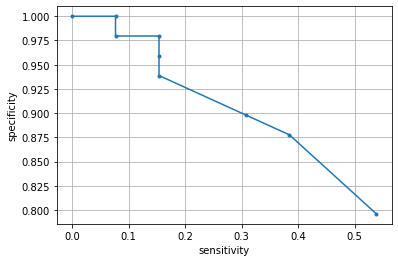

<Figure size 3600x2880 with 0 Axes>

In [5]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
# plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

**rulefit**

100%|██████████| 30/30 [00:00<00:00, 2576.88it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

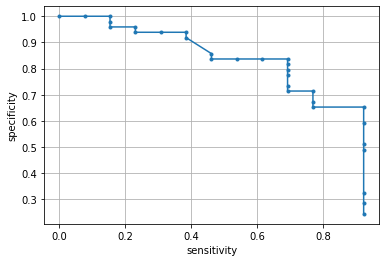

In [6]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitClassifier(max_rules=25, random_state=0, tree_size=4, n_estimators=1000)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [7]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
54,SubInj_TorsoTrunk <= 0.5 and Predisposed <= 0.5 and HighriskDiving <= 0.5 and FocalNeuroFindings2 <= 0.5,-0.20
63,Predisposed <= 0.5 and Immobilization2 <= 0.5 and SubInj_Head <= 0.5,-0.03
57,Immobilization2 <= 0.5 and MedsRecd2 <= 0.5,-0.05
61,Immobilization2 <= 0.5 and MedsRecd2 <= 0.5,-0.07
60,SubInj_TorsoTrunk <= 0.5 and FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5,-0.03
52,Torticollis2 <= 0.5 and FocalNeuroFindings <= 0.5 and Immobilization2 <= 0.5,-0.02
55,SubInj_TorsoTrunk <= 0.5 and Predisposed <= 0.5 and FocalNeuroFindings2 <= 0.5 and Position_IDEMS <= 0.5,-0.22
56,HighriskDiving <= 0.5 and HighriskMVC <= 0.5 and FocalNeuroFindings2 <= 0.5,-0.35
62,HighriskMVC <= 0.5 and Torticollis2 <= 0.5 and FocalNeuroFindings <= 0.5,-0.10
51,Torticollis2 <= 0.5 and FocalNeuroFindings <= 0.5 and MedsRecd <= 0.5,-0.26


In [8]:
X_train.columns

Index(['AlteredMentalStatus', 'LOC', 'ambulatory', 'FocalNeuroFindings',
       'PainNeck', 'PosMidNeckTenderness', 'TenderNeck', 'Torticollis',
       'SubInj_Head', 'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk',
       'Predisposed', 'HighriskDiving', 'HighriskFall', 'HighriskHanging',
       'HighriskHitByCar', 'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc',
       'axialloadtop', 'Clotheslining', 'AlteredMentalStatus2',
       'FocalNeuroFindings2', 'PainNeck2', 'PosMidNeckTenderness2',
       'TenderNeck2', 'Torticollis2', 'subinj_Head2', 'subinj_Face2',
       'subinj_Ext2', 'subinj_TorsoTrunk2', 'is_ems', 'Position_IDEMS',
       'Position_L', 'Position_ND', 'Position_PA', 'Position_S', 'Position_W',
       'Immobilization2', 'MedsRecd', 'MedsRecd2', 'gender_F', 'age_infant',
       'age_preschool', 'age_school_age', 'age_adolescents'],
      dtype='object')

### original CDR

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
def baseline_cdr_predict(X, use_2 = False):
    num_conditions = (X['AlteredMentalStatus2'] + 
                      X['FocalNeuroFindings2'] + 
                      X['PainNeck2'] +
                      X['Torticollis2'] + 
                      X['subinj_TorsoTrunk2'] + 
                      X['Predisposed'] + 
                      X['HighriskDiving'] + 
                      X['HighriskMVC'])
    preds = (num_conditions > 0).astype(int).values
    return preds

In [11]:
X_all = pd.concat((X_train, X_tune, X_test))
y_all = np.concatenate((y_train, y_tune, y_test), axis=0)

In [12]:
def simple_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    print("Specificity: ", specificity)
    print("Sensitivity: ", sensitivity)

In [13]:
simple_report(y_train, baseline_cdr_predict(X_train))

              precision    recall  f1-score   support

           0       0.98      0.32      0.49      1570
           1       0.20      0.97      0.34       279

    accuracy                           0.42      1849
   macro avg       0.59      0.65      0.41      1849
weighted avg       0.87      0.42      0.47      1849

Specificity:  0.3248407643312102
Sensitivity:  0.967741935483871


In [14]:
print(simple_report(y_tune, baseline_cdr_predict(X_tune)))

              precision    recall  f1-score   support

           0       1.00      0.27      0.42        49
           1       0.27      1.00      0.42        13

    accuracy                           0.42        62
   macro avg       0.63      0.63      0.42        62
weighted avg       0.85      0.42      0.42        62

Specificity:  0.2653061224489796
Sensitivity:  1.0
None


## skope

100%|██████████| 19/19 [00:00<00:00, 1865.49it/s]


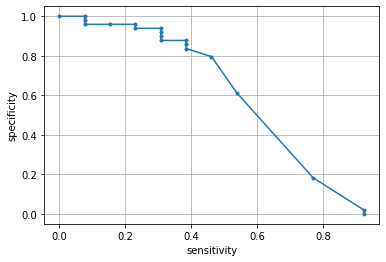

In [15]:
skope = imodels.SkopeRulesClassifier(precision_min=0.01, recall_min=0.1, n_estimators=10, max_samples=0.8, bootstrap=True, max_depth=3, random_state=0)
skope.fit(X_train, y_train)
stats, threshes = predict_and_save(skope, model_name='skope')

In [16]:
len(skope.rules_)

39

100%|██████████| 15/15 [00:00<00:00, 1487.06it/s]


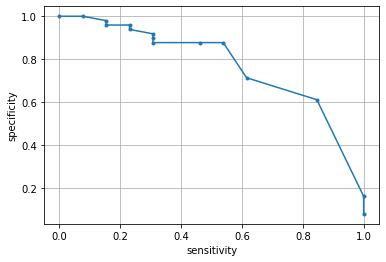

In [17]:
boost = imodels.BoostedRulesClassifier(n_estimators=10,)
boost.fit(X_train, y_train)
stats, threshes = predict_and_save(boost, model_name='boostedrules')

In [18]:
[(r, w) for r, w in boost.rules_]

[('X_4 <= 0.5', [-0.6634306583274884]),
 ('X_4 > 0.5', [-0.060700131121008846]),
 ('X_24 <= 0.5', [-0.051299483661640805]),
 ('X_24 > 0.5', [0.1674904703161346]),
 ('X_42 <= 0.5', [0.0010857025190954845]),
 ('X_42 > 0.5', [0.08940860920354786]),
 ('X_42 <= 0.5', [-0.03506521753805947]),
 ('X_42 > 0.5', [0.10053491896111749]),
 ('X_25 <= 0.5', [-0.01241107838501217]),
 ('X_25 > 0.5', [0.0612638532111663]),
 ('X_38 <= 0.5', [0.03604177931772304]),
 ('X_38 > 0.5', [-0.11332277778113774]),
 ('X_1 <= 0.5', [-0.02447701146549805]),
 ('X_1 > 0.5', [0.04873842944695341]),
 ('X_40 <= 0.5', [-0.0011686015260307524]),
 ('X_40 > 0.5', [0.03205542578739457]),
 ('X_28 <= 0.5', [0.0057622519977085776]),
 ('X_28 > 0.5', [0.056997980061563466]),
 ('X_28 <= 0.5', [-0.0044984005725685824]),
 ('X_28 > 0.5', [0.04201477590126422])]

100%|██████████| 14/14 [00:00<00:00, 1685.52it/s]


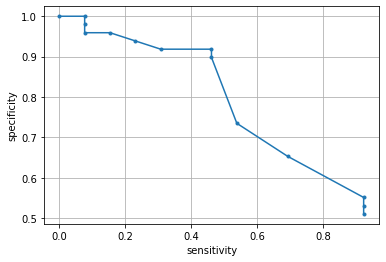

In [19]:
saps = imodels.SaplingSumClassifier(max_rules=20)
saps.fit(X_train.values, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(saps, model_name='saps')

In [20]:
print(saps)

------------
FocalNeuroFindings <= 0.500 (Tree #0 root)
	HighriskMVC <= 0.500 (split)
		SubInj_TorsoTrunk <= 0.500 (split)
			FocalNeuroFindings2 <= 0.500 (split)
				Val: 0.092 (leaf)
				Val: 0.235 (leaf)
			subinj_Head2 <= 0.500 (split)
				Val: 0.167 (leaf)
				Val: 0.508 (leaf)
		Val: 0.191 (leaf)
	AxialLoadAnyDoc <= 0.500 (split)
		Val: 0.369 (leaf)
		Val: 0.563 (leaf)

	+
MedsRecd2 <= 0.500 (Tree #1 root)
	Immobilization2 <= 0.500 (split)
		is_ems <= 0.500 (split)
			Predisposed <= 0.500 (split)
				Val: 0.027 (leaf)
				Val: 0.787 (leaf)
			Val: -0.062 (leaf)
		PainNeck <= 0.500 (split)
			Torticollis2 <= 0.500 (split)
				Val: -0.021 (leaf)
				Val: 0.830 (leaf)
			Position_S <= 0.500 (split)
				Val: 0.621 (leaf)
				Val: -0.295 (leaf)
	PainNeck2 <= 0.500 (split)
		Predisposed <= 0.500 (split)
			Val: 0.014 (leaf)
			Val: 0.766 (leaf)
		MedsRecd <= 0.500 (split)
			Val: 0.916 (leaf)
			Clotheslining <= 0.500 (split)
				Position_S <= 0.500 (split)
					Val: 0.282 (leaf)
					

In [21]:
stats['spec'][1], stats['sens'][1]

(0.5306122448979592, 0.9230769230769231)

## neural net

In [22]:
from sklearn.neural_network import MLPClassifier

/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 1595/1595 [00:00<00:00, 2014.69it/s]
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 62/62 [00:00<00:00, 2417.51it/s]


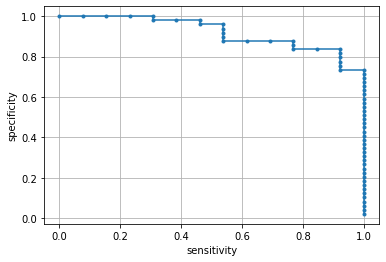

In [23]:
nn = MLPClassifier(hidden_layer_sizes=(100, ))
nn.fit(X_train, y_train)
stats, threshes = predict_and_save(nn, model_name='nn')

**GOSDT**

In [24]:
# gosdt_costs = np.array([[0.0, 0.5],
#                         [0.1, 0.0]])
# gosdt_costs_df = pd.DataFrame(gosdt_costs, columns=[0, 1])
# gosdt_costs_path = oj(MODELS_DIR, 'gosdt_costs.csv')
# gosdt_costs_df.to_csv(gosdt_costs_path)

In [25]:
# gosdt = imodels.OptimalTreeClassifier(regularization=0.01, 
#                                       cancellation=False,
#                                       look_ahead=False,
#                                       similar_support=False,
#                                       feature_exchange=False,
#                                       continuous_feature_exchange=False,
#                                       balance=False, time_limit=5)#, costs=gosdt_costs_path)
# gosdt.fit(X_train, y_train, feature_names=feature_names)
# print(gosdt)

# simple_report(y_tune, gosdt.predict(X_tune))

In [26]:
# print(str(gosdt.tree_))

**CORELS**

In [27]:
# corels = imodels.OptimalRuleListClassifier(
#     c=0.001, n_iter=100000, map_type="prefix", policy="curious", verbosity=[], ablation=0, max_card=2, min_support=0.2, random_state=0)
# corels.fit(X_train, y_train, feature_names=feature_names)
# stats, threshes = predict_and_save(corels, model_name='corels')
# print(corels)

# print(classification_report(y_tune, gosdt.predict(X_tune)))
# tn, fp, fn, tp = confusion_matrix(y_tune, gosdt.predict(X_tune)).ravel()
# specificity = tn / (tn+fp)
# print("Specificity: ", specificity)

### Stablerules

In [28]:
from imodels.experimental import stablelinear

In [29]:
weak_learners = [rulefit, skope, boost]

In [30]:
stbl = stablelinear.StableLinearClassifier(weak_learners=weak_learners, max_complexity=-1, alpha=0.1, max_rules=None, penalty='l1')
stbl.fit(X_train, y_train)

StableLinearClassifier(alpha=0.1, max_complexity=-1, max_rules=None,
                       weak_learners=[RuleFitClassifier(max_rules=25,
                                                        n_estimators=1000,
                                                        random_state=0),
                                      SkopeRulesClassifier(bootstrap=True,
                                                           precision_min=0.01,
                                                           random_state=0,
                                                           recall_min=0.1),
                                      BoostedRulesClassifier()])

100%|██████████| 33/33 [00:00<00:00, 2118.08it/s]


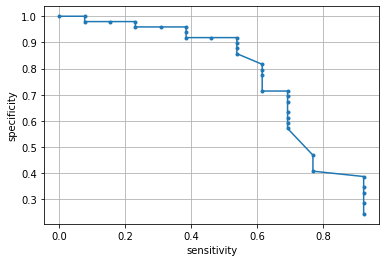

In [31]:
stats, threshes = predict_and_save(stbl, model_name='stbl')

In [32]:
stbl.rules_

[FocalNeuroFindings <= 0.5,
 HighriskDiving <= 0.5,
 Position_IDEMS <= 0.5,
 MedsRecd <= 0.5,
 HighriskMVC <= 0.5,
 subinj_Head2 > 0.5,
 FocalNeuroFindings2 <= 0.5,
 is_ems > 0.5,
 MedsRecd2 <= 0.5,
 Immobilization2 <= 0.5 and MedsRecd2 <= 0.5,
 PainNeck2 > 0.5,
 Torticollis2 <= 0.5,
 FocalNeuroFindings <= 0.5 and MedsRecd <= 0.5 and Torticollis2 <= 0.5,
 AxialLoadAnyDoc <= 0.5,
 subinj_TorsoTrunk2 <= 0.5,
 Immobilization2 <= 0.5,
 gender_F > 0.5]

In [33]:
stats['sens'][20], stats['spec'][20]

(0.5384615384615384, 0.8979591836734694)

# look at all the results

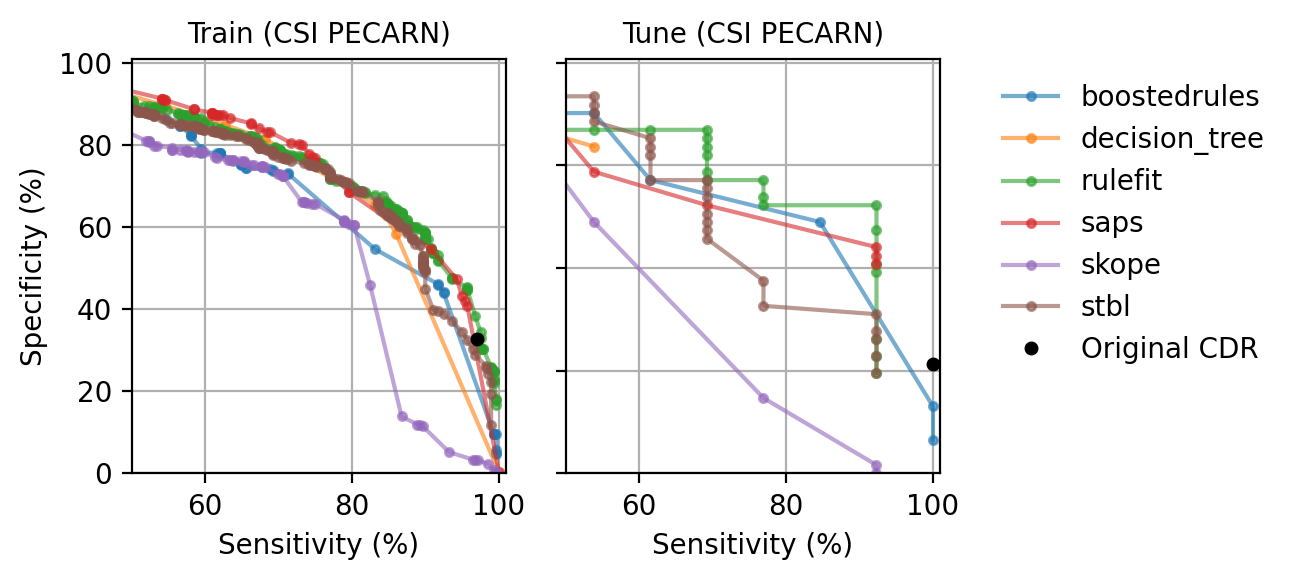

In [37]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_train':
        plt.plot(96.96, 32.84, 'o', color='black', label='Original CDR', ms=4)
    if suffix == '_tune':
        plt.plot(100.0, 26.53, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (CSI PECARN)', 'Tune (CSI PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
#plt.savefig('figs/metrics_3_splits')
plt.show()